## Rwanda Project - Seasonality within Rwanda
### The purpose of the project is to check for seasonality in the Rwanda during 2013-2016.This is to aid in the identiying the best time to collect images for the landcover classification for the project.



In [ ]:
from google.colab import drive
root = '/content/gdrive'
drive.mount(root)

Mounted at /content/gdrive


In [ ]:
%%capture
%pip install leafmap
%pip install localtileserver
%pip install rio-cogeo
%pip install rioxarray

In [ ]:
import os
import re
import sys
from pathlib import Path
from subprocess import run
import pandas as pd
import numpy as np
import leafmap.leafmap as leafmap
import localtileserver
import geopandas as gpd
import rasterio
from rasterio.plot import show
import rioxarray as rxr
import xarray as xr

In [ ]:
root = '/content/gdrive/MyDrive'
img_dir = Path(root) / "Rwanda"
os.listdir(img_dir)

['Rwanda']

## Import and authenticate the Google Earth Engine Python API

Along with the [`geemap`](https://geemap.org/) library.

In [ ]:
import ee
import geemap
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from matplotlib.dates import date2num

import json
from geemap import geojson_to_ee, ee_to_geojson
from ipyleaflet import GeoJSON


In [ ]:
# Authenticate/Initialize the Earth Engine API
ee.Authenticate()
ee.Initialize(project = 'ee-addy')

In [ ]:
# Path were the Rwanda geojson is stored
rwanda_path = f"{img_dir}/Rwanda2.geojson"
rwanda_path1 = f"{img_dir}/Non_Urban_Victoria.geojson"
rwanda_path2 = f"{img_dir}/Non_Urban_Albertine.geojson"
# Load GeoJSON FeatureCollection
rwanda = geemap.geojson_to_ee(rwanda_path)
victoria = geemap.geojson_to_ee(rwanda_path1)
albertine = geemap.geojson_to_ee(rwanda_path2)



## Creating Area of Interest (aoi)
myaoi

In [ ]:
#albertine

In [ ]:
# Create an instance of geemap
map = geemap.Map()
map.add_basemap()
map.add_basemap("SATELLITE")
map.setCenter(29.874760,-1.898658, 7)
map.addLayer(rwanda, {'color': 'red'}, 'Rwanda')
map.addLayer(victoria, {'color': 'blue'}, 'Rwanda')
#map.addLayer(albertine, {'color': 'red'}, 'Rwanda')
map

Map(center=[-1.898658, 29.87476], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Searc…

In [ ]:
# Create an ROI by drawning polygon above
roi = map.draw_features

# Create a feature collection from the polygon
myroi = ee.FeatureCollection(roi)

# Display the roi
map.addLayer(myroi, {'color': 'FF0000'}, 'My Region of Interest')
map

Map(bottom=16857.0, center=[-1.898658, 29.87476], controls=(WidgetControl(options=['position', 'transparent_bg…

## Functions
functions for image collection, evi and harmonics

In [ ]:

 # landsat 2 cloud mask
def mask_clouds(image):
    score = ee.Algorithms.Landsat.simpleCloudScore(image).select('cloud')
    mask = score.lt(10)
    return image.updateMask(mask)

# EVI function
def add_evi(image):
  # Select the ban used for evi (B5,B4,B2)
  nir = image.select('B5')
  red = image.select('B4')
  blue = image.select('B2')
  # calculating EVI .  formaula adaptored from chatgpt
  evi = ee.Image(2.5).multiply(
        nir.subtract(red).divide(nir.add(red.multiply(6.0)).subtract(blue.multiply(7.5)).add(1.0))
    ).rename('EVI')\
    .float()
  return image.addBands(evi)

# Cropping image to AOI
def cropper(image, cropshape=rwanda):
  return image.clip(cropshape)

# Display a single image from a collection
def display_image(collection, index, vis_params, layer_name, map):
  collection_list = collection.toList(collection.size())
  scene = ee.Image(collection_list.get(index))
  return map.addLayer(scene, vis_params, layer_name)


#FUNCTIONS FOR HARMONICS
# Function to get a sequence of band names for harmonic terms.
def construct_band_names(base, list):
    return ee.List(list).map(
        lambda i: ee.String(base).cat(ee.Number(i).int().format())
    )

def add_dependents(image, date_string="2012-01-01"):
    # Compute time in fractional years since the epoch.
    years = image.date().difference(date_string, 'year')
    timeRadians = ee.Image(years.multiply(2 * math.pi)).rename('t')
    constant = ee.Image(1)
    return image.addBands(constant).addBands(timeRadians.float())

def add_harmonics(image, freqs):
    # Make an image of frequencies
    frequencies = ee.Image.constant(freqs)
    # This band should represent time in radians
    time = ee.Image(image).select('t')
    # Get the cosine terms
    cosines = time.multiply(frequencies).cos().rename(cos_names)
    # Get the sin terms
    sines = time.multiply(frequencies).sin().rename(sin_names)
    return image.addBands(cosines).addBands(sines)


## Harmonic variables and inputs

In [ ]:
# The dependent variable we are modeling.
dependent = 'EVI'

# The number of cycles per year to model.
harmonics = 1

# Make a list of harmonic frequencies to model.These also serve as band name suffixes.
harmonic_frequencies = ee.List.sequence(1, harmonics)

# Construct lists of names for the harmonic terms.
cos_names = construct_band_names('cos_', harmonic_frequencies)
sin_names = construct_band_names('sin_', harmonic_frequencies)

# Independent variables.
independents = ee.List(['constant', 't'])\
    .cat(cos_names).cat(sin_names)

## Filter, mask, ndvi, crop a Landsat Collection

Using the AOI made above, spatially and temporally filter it.

In [ ]:
# spatial and temporal filtering of sentinel 2 collection
s2_filtered = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')\
.filterBounds(rwanda)\
  .filterDate('2013-01-01', '2016-12-31')\
  #.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

In [ ]:
s2_masked =s2_filtered\
  .map(mask_clouds)\
  .map(cropper)\


s2_EVI = s2_masked\
  .map(add_evi).select('EVI')\
  .map(add_dependents)\
  .map(lambda image: add_harmonics(image, harmonic_frequencies))

In [ ]:
s2_EVI
true_params ={'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max':0.2}
evi_params = {"bands": ['EVI'], "min": -0.5, "max": 1}
m = geemap.Map()
m.add_basemap()
m.add_basemap("SATELLITE")
m.setCenter(29.874760,-1.898658, 7)
#m.addLayer(rwanda, {'color': 'red'}, 'Rwanda')

m.centerObject(rwanda, 8)

m.addLayer(s2_masked, true_params, 'rwanda')
m.addLayer(myroi, {'color': 'FF0000'}, 'My Region of Interest')
m

Map(center=[-1.9999117414057426, 29.926089549183356], controls=(WidgetControl(options=['position', 'transparen…

## Harmonics

In [ ]:
# The output of the regression reduction is a 4x1 array image.
harmonic_trend = s2_EVI\
    .select(independents.add(dependent))\
    .reduce(ee.Reducer.linearRegression(independents.length(), 1))

# Turn the array image into a multi-band image of coefficients.
harmonic_trend_coefficients = harmonic_trend\
    .select('coefficients')\
    .arrayProject([0])\
    .arrayFlatten([independents])

# Compute fitted values and setting it as band in the image
def fit_values(image):
  fitted = image.select(independents) \
    .multiply(harmonic_trend_coefficients) \
    .reduce('sum') \
    .rename('fitted')
  return image.addBands(fitted)

# Map fitted values to s2_EVi
fitted_Harmonic_UNSMOOTH = s2_EVI.map(fit_values)

In [ ]:
# Pull out the three bands we're going to visualize.
sin = harmonic_trend_coefficients.select('sin_1')
cos = harmonic_trend_coefficients.select('cos_1')

# Do some math to turn the first-order Fourier model into
# hue, saturation, and value in the range[0,1].
magnitude = cos.hypot(sin).multiply(5)
phase = sin.atan2(cos).unitScale(-math.pi, math.pi)
val = s2_EVI.select('EVI').reduce('mean')

# Turn the HSV data into an RGB image and add it to the map.
seasonality = ee.Image.cat(phase, magnitude, val).hsvToRgb()

In [ ]:
# Function to create mean monthly composite
def create_mean_monthly_composite(year, month):
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')

    # Filter images for the specified month
    monthly_images = fitted_Harmonic_UNSMOOTH.filterDate(start_date, end_date)

    # Calculate the mean composite for the month
    mean_composite = monthly_images.mean()

    # Set the properties
    mean_composite = mean_composite.set({
        'system:time_start': start_date.millis(),
        'year': year,
        'month': month
    })

    return mean_composite

# Specify the years and months for which you want to create mean composites
years = [2013]
months = list(range(1, 13))

# Create mean monthly composites for each year and month
monthly_composites2013 = []
for year in years:
    for month in months:
        composite = create_mean_monthly_composite(year, month)
        monthly_composites2013.append(composite)


##### 2014 composite
years2014 = [2014]
months2014 = list(range(1, 13))

# Create mean monthly composites for each year and month
monthly_composites2014 = []
for year in years2014:
    for month in months2014:
        composite = create_mean_monthly_composite(year, month)
        monthly_composites2014.append(composite)

# Print the resulting ImageCollection
monthly_composites2013
#monthly_composites2014

In [ ]:
# check monlhty composites for 2013 and image with index 0 and 1 do not bands or no image
# thus remove those images from the list of images
# Specify the indices to remove (0-based index)
image_withZerobands = [0, 1]

# Use list comprehension to create a new list without the specified indices
# This becomes the new images for 2013.
filtered_collection2013 = [image for index, image in enumerate(monthly_composites2013)\
                   if index not in image_withZerobands]
filtered_collection2014 = [image for index, image in enumerate(monthly_composites2014)\
                   if index not in image_withZerobands]

# Convert the list of composites to an ImageCollection
monthly_collection2013 = ee.ImageCollection(filtered_collection2013)
monthly_collection2014 = ee.ImageCollection(filtered_collection2014)
monthly_collection2013
#monthly_collection2014


## Funtions to collect values and fitted values for plotting

### I used myroi instead of the whole of Rwanda to avoid memory limitation.

In [ ]:
def reduce_evi(image, geom=myroi, scale=30):
  # evi values
    unsmooth_evi = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geom,
        scale=scale,
        maxPixels=1e8
    ).get('EVI')
  # fitted values
    fitted = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geom,
        scale=scale,
        maxPixels=1e8
    ).get("fitted")
    return image.set('date', image.date().format()).\
    set('EVI', unsmooth_evi)#.set('fitted', fitted)


# fitted harmonics for evi and smooth
fH_UNSMOOTH_pt2013 = monthly_collection2013.select(['EVI'])\
    .map(reduce_evi)

fH_UNSMOOTH_pt2014 = monthly_collection2014.select(['EVI'])\
    .map(reduce_evi)

fH_UNSMOOTH_pt2013

In [ ]:
# extract date, evi, fitted ad smoothed_evi values to lists
harmonic_list_UNSMOOTH2013 = fH_UNSMOOTH_pt2013.select(['date', 'EVI'])\
    .reduceColumns(ee.Reducer.toList(2), ['date','EVI'])\
    .values().get(0)

harmonic_list_UNSMOOTH2014 = fH_UNSMOOTH_pt2014.select(['date', 'EVI'])\
    .reduceColumns(ee.Reducer.toList(2), ['date','EVI'])\
    .values().get(0)

harmonic_list_UNSMOOTH2013

In [ ]:
# Harmonic values to dataframes
harmonic_UNSMOOTH_df2013 = pd.DataFrame(
    harmonic_list_UNSMOOTH2013.getInfo(), columns=['date','EVI'])\
    .sort_values(by="date", ignore_index=True)

harmonic_UNSMOOTH_df2014 = pd.DataFrame(
    harmonic_list_UNSMOOTH2014.getInfo(), columns=['date','EVI'])\
    .sort_values(by="date", ignore_index=True)


In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()
#harmonic_UNSMOOTH_df2013, harmonic_UNSMOOTH_df2014
#harmonic_UNSMOOTH_df2014


In [ ]:
harmonic_UNSMOOTH_df2013["date"] = pd.to_datetime(harmonic_UNSMOOTH_df2013["date"])\
  .dt.strftime("%Y-%m-%d")

harmonic_UNSMOOTH_df2013 = harmonic_UNSMOOTH_df2013.groupby(["date"]).mean().reset_index()


harmonic_UNSMOOTH_df2014["date"] = pd.to_datetime(harmonic_UNSMOOTH_df2014["date"])\
  .dt.strftime("%Y-%m-%d")

harmonic_UNSMOOTH_df2014 = harmonic_UNSMOOTH_df2014.groupby(["date"]).mean().reset_index()

In [ ]:
harmonic_UNSMOOTH_df2013
harmonic_UNSMOOTH_df2014

,date,EVI


## plot

TypeError: no numeric data to plot

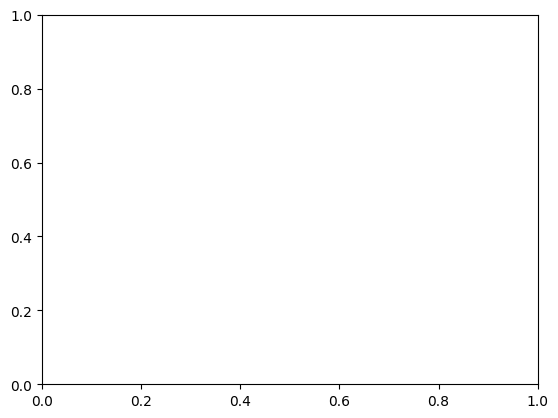

In [ ]:
import calendar
# Create a single axes instance
ax = plt.gca()

# Plot the two lines on the same axes
harmonic_UNSMOOTH_df2013.plot(x='date', y=['EVI'], kind='line', figsize=(10,4), rot=40, color=['#0000FF','#FF00FF'], ax=ax)
harmonic_UNSMOOTH_df2014.plot(x='date', y=['EVI'], kind='line', figsize=(10,4), rot=40, color=['#800020','#FF00FF'], ax=ax)

# Set labels for the axes
month_names = list(calendar.month_abbr)[1:]
ax.set_xticks(range(len(month_names)))
ax.set_xticklabels(month_names)

# Legend
ax.legend(['2013 Landsat EVI', '2014 Landsat EVI', 'Fitted Harmonic'], loc='upper right')

# Display plot and title
plt.title('Harmonic Time Series for Rwanda EVI and Fitted Harmonic')
plt.show()

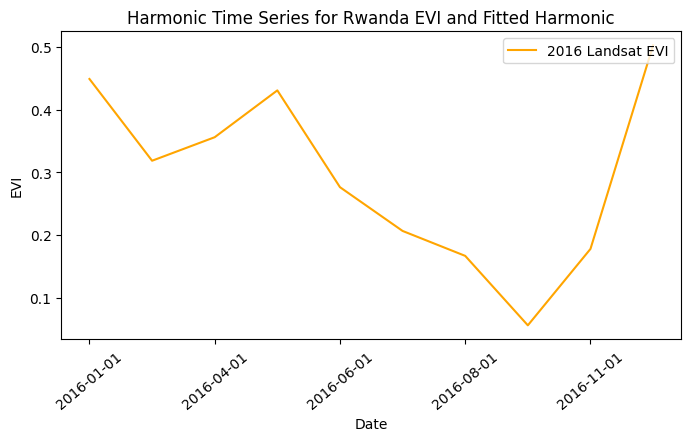

In [ ]:

# plot the two line on the same axes, us an instance for for the matplotlin.axes

#ax = harmonic_UNSMOOTH_df2013.plot(x='date', y=['EVI'], kind='line', figsize=(8,4),\
                               #rot=40, color=['#ff0000','#FF00FF'])
ay = harmonic_UNSMOOTH_df2014.plot(x='date', y=['EVI'], kind='line', figsize=(8,4),\
                                   rot=40, color=['#FFA500','#FF00FF'])

# Add marker for the lowest EVI value
#ax.scatter(lowest_evi_date, lowest_evi_value, color='red', label='Lowest EVI', s=50)
#ax.annotate(f'Lowest EVI: {lowest_evi_value:.2f}', (lowest_evi_date, lowest_evi_value),
            #textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')


# setting labels for the axes
#ax.set_xlabel('Date')
#ax.set_ylabel('EVI')

ay.set_xlabel('Date')
ay.set_ylabel('EVI')

# legend
ay.legend(['2016 Landsat EVI', 'Fitted Harmonic'], loc='upper right')
#ax.legend(['2013 Landsat EVI', 'Fitted Harmonic'], loc='upper right')


# display plot and title
plt.title('Harmonic Time Series for Rwanda EVI and Fitted Harmonic')
plt.show()
None

In [ ]:
#long rainy season: March to May, and short rainy season: September to November.
#These seasons alternate with the long dry season: June to August, and short dry
#season: December to February.

### Display images
- Display 10th images By index (9)
- display median sentinel 2 evi and smoothed median sentinel 2 evi

In [ ]:
# visualization parameters false color, evi and seasonality
false_params ={'bands': ['B5', 'B4', 'B2'], 'min': 0, 'max': 3000}
evi_params = {"bands": ['EVI'], "min": -0.5, "max": 1}

map = geemap.Map()
#map.setCenter(-0.2, 9.2, 9.5)
map.centerObject(rwanda, 9)

display_image(s2_masked, 9, false_params, '10th Sentinel 2 image', map)
map.addLayer(s2_EVI.select('EVI'), evi_params, 'EVI')
map.addLayer(seasonality, {}, 'Seasonality')
map.addLayer(rwanda,{}, 'My Area of interest')
map

Map(center=[-1.9999117414057426, 29.926089549183356], controls=(WidgetControl(options=['position', 'transparen…